# Manifold Learning on Face Data

**Atul Kumar Sinha, Karttikeya Mangalam and Prakhar Srivastava**

In this project, we explore manifold learning on face data to embed high dimensional face images into a lower dimensional embedding. We hypothesize that euclidean distance in this lower dimensional embedding reflects image similarity in a better way. This hypothesis is tested by choosing path(s) that contain a number of points (images) from this lower dimensional space which represent an ordererd set of images. These images are then combined to generate a video which shows a smooth morphing.

In [1]:
import os
import numpy as np
from sklearn.tree import ExtraTreeRegressor
from sklearn import manifold
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import animation
from PIL import Image
import pickle
from scipy.linalg import norm

import networkx as nx
from scipy import spatial


from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

plt.rcParams["figure.figsize"] = (8,6)

Loading BokehJS ...

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH = './img_align_celeba'

In [4]:
def load_image(filepath):
    ''' Loads an image at the path specified by the parameter filepath '''
    im = Image.open(filepath)
    return im

In [5]:
def show_image(im):
    ''' Displays an image'''
    fig1, ax1 = plt.subplots(1, 1)
    ax1.imshow(im, cmap='gray');
    return

In [6]:
#Loads image files from all sub-directories

imgfiles = [os.path.join(root, name)
             for root, dirs, files in os.walk(PATH)
             for name in files
             if name.endswith((".jpg"))]

## Dataset

We are using [`CelebA Dataset`](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) which is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

We randomly downsample it by a factor of 30 for computational reasons.

In [7]:
#N=int(len(imgfiles)/30)
N=len(imgfiles)
print("Number of images = {}".format(N))
test = imgfiles[0:N]

Number of images = 6753


In [8]:
test[1]

'./img_align_celeba/110369.jpg'

## Loading the data

In [9]:
sample_path = imgfiles[0]
sample_im = load_image(sample_path)
sample_im = np.array(sample_im)
img_shape = (sample_im.shape[0],sample_im.shape[1])

In [10]:
ims = np.zeros((N, sample_im.shape[1]*sample_im.shape[0]))
for i, filepath in enumerate(test):
    im = load_image(filepath)
    im = np.array(im)
    im = im.mean(axis=2)
    im = np.asarray(im).ravel().astype(float)
    ims[i] = im

## Learning the Manifold

We are using [Isomap](https://en.wikipedia.org/wiki/Isomap) for dimensionality reduction as we believe that the face image data lies on a structured manifold in a higher dimension and thus is embeddable in a much lower dimension without much loss of information.

Further, Isomap is a graph based technique which aligns with our scope.

In [11]:
#iso = manifold.Isomap(n_neighbors=2, n_components=3, max_iter=500, n_jobs=-1)

In [12]:
#Z = iso.fit_transform(ims)    #don't run, can load from pickle as in below cells

In [13]:
#saving the learnt embedding

#with open('var6753_n2_d3.pkl', 'wb') as f: #model learnt with n_neighbors=2 and n_components=3
#    pickle.dump(Z,f)

#with open('var6753_n2_d2.pkl', 'wb') as f: #model learnt with n_neighbors=2 and n_components=2
#    pickle.dump(Z,f)

#with open('var6753_n4_d3.pkl', 'wb') as f: #model learnt with n_neighbors=4 and n_components=3
#    pickle.dump(Z,f)

In [14]:
with open('var6753_n2_d2.pkl', 'rb') as f:
    Z = pickle.load(f)

In [15]:
#Visualizing the learnt 3D-manifold in two dimensions

source = ColumnDataSource(
        data=dict(
            x=Z[:, 0],
            y=Z[:, 1],
            desc=list(range(Z.shape[0])),
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover],title="Mouse over the dots")

p.circle('x', 'y', size=10, source=source)
show(p)

## Regeneration from Lower Dimensional Space

While traversing the chosen path, we are also sub sampling in the lower dimensional space in order to create smooth transitions in the video. We naturally expect smoothness as points closer in the lower dimensional space should correspond to similar images. Since we do not have an exact representation for these sub-sampled points in the original image space, we need a method to map these back to the higher dimension.

We will be using [Extremely randomized trees](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.7485&rep=rep1&type=pdf) for regression.

As an alternative, we would also be testing convex combination approach to generate representations for the sub-sampled points.

## Path Selection Heuristic

### Method 1

Generating k-nearest graph using the Gaussian kernel. We further generate all pair shortest paths from this graph and randomly choose any path from that list for visualization. For regeneration of sub-sampled points, we use Extremely randomized trees as mentioned above.

In [16]:
#Mapping the regressor from low dimension space to high dimension space

lin = ExtraTreeRegressor(max_depth=19)
lin.fit(Z, ims)

ExtraTreeRegressor(criterion='mse', max_depth=19, max_features='auto',
          max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [17]:
lin.score(Z, ims)

0.90199726393173751

Text(0.5,1,'Reconstructed')

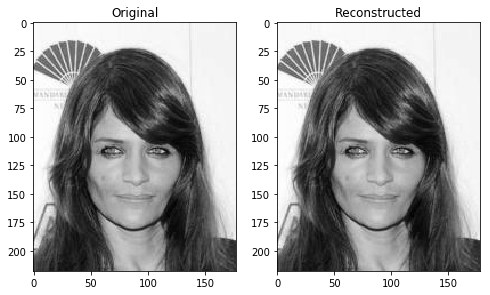

In [18]:
pred = lin.predict(Z[502].reshape(1, -1));
fig_new, [ax1,ax2] = plt.subplots(1,2)
ax1.imshow(ims[502].reshape(*img_shape), cmap = 'gray')
ax1.set_title('Original')
ax2.imshow(pred.reshape(*img_shape), cmap = 'gray')
ax2.set_title('Reconstructed')

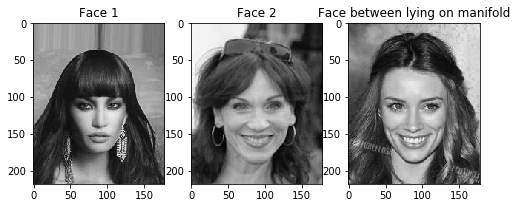

In [19]:
person1 = 34
person2 = 35
test = ((Z[person1] + Z[person2]) / 2) #+ 0.5*np.random.randn(*Z[person1].shape)
pred = lin.predict(test.reshape(1, -1))
fig_newer, [ax1, ax2, ax3] = plt.subplots(1, 3)
ax1.imshow(ims[person1].reshape(*img_shape), cmap = 'gray')
ax1.set_title('Face 1')
ax2.imshow(ims[person2].reshape(*img_shape), cmap = 'gray')
ax2.set_title('Face 2')
ax3.imshow(pred.reshape(*img_shape), cmap = 'gray')
ax3.set_title('Face between lying on manifold');

In [20]:
distances = spatial.distance.squareform(spatial.distance.pdist(Z, 'braycurtis'))

In [21]:
kernel_width = distances.mean()
weights = np.exp(-np.square(distances) / (kernel_width ** 0.1))
for i in range(weights.shape[0]):
    weights[i][i] = 0

In [22]:
NEIGHBORS = 2
#NEIGHBORS = 100
# Your code here.

#Find sorted indices of weights for each row
indices = np.argsort(weights, axis = 1)

#Create a zero matrix which would later be filled with sparse weights
n_weights = np.zeros((weights.shape[0], weights.shape[1]))

#Loop that iterates over the 'K' strongest weights in each row, and assigns them to sparse matrix, leaving others zero
for i in range(indices.shape[0]):
    for j in range(indices.shape[1] - NEIGHBORS, indices.shape[1]):
        col = indices[i][j]
        n_weights[i][col] = weights[i][col]  

#Imposing symmetricity
big = n_weights.T > n_weights
n_weights_s = n_weights - n_weights * big + n_weights.T * big

In [23]:
G = nx.from_numpy_matrix(n_weights_s)

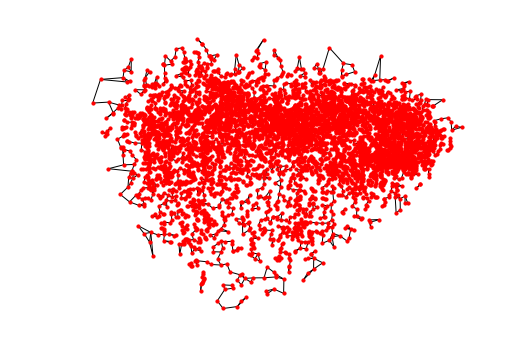

In [24]:
pos = {}
for i in range(Z.shape[0]):
    pos[i] = Z[i,0:2]

fig2,ax2 = plt.subplots()
nx.draw(G, pos, ax=ax2, node_size=10)

In [25]:
imlist=nx.all_pairs_dijkstra_path(G)[0][102]   #choosing the path starting at node 0 and ending at node 102
imlist

[0, 2264, 874, 1330, 6412, 1325, 781, 3607, 483, 1106, 6316, 1405, 102]

In [26]:
N=25                             #number of sub-samples between each consecutive pair in the path
lbd = np.linspace(0, 1, N)
counter = 0
for count, i in enumerate(imlist):
    if count != len(imlist) - 1:
        person1 = i
        person2 = imlist[count + 1]
        for j in range(N):
            test = (lbd[j] * Z[person2]) + ((1 - lbd[j]) * Z[person1])
            pred = lin.predict(test.reshape(1, -1))
            im = Image.fromarray(pred.reshape(*img_shape))
            im = im.convert('RGB')
            im.save('{}.png'.format(counter))
            counter += 1

In [27]:
os.system("ffmpeg -f image2 -r 10 -i ./%d.png -vcodec mpeg4 -y ./method1.mp4")

0

Please check the generated video in the same enclosing folder.

Observing the output of the tree regressor we notice sudden jumps in the reconstructed video. We suspect that these discontinuities are either an artefact of the isomap embedding in a much lower dimension or because of the reconstruction method. 

To investigate further we plot the frobenius norm of the sampled image in the isomap domain and that of the reconstructed image in the original domain. Since, we are sampling on a linear line between two images, the plot of the norm of the image of expected to be either an increasing or a decreasing linear graph. This indeed turnout the case for the sampled images in the isomap domain.

However, as we suspected, after reconstruction we observed sudden jumps in the plot. Clearly, this is because of the tree regressor which is overfitting the data, in which case there are sudden jumps in the plot.

In [28]:
norm_vary = list()
norm_im = list()
lbd = np.linspace(0, 1, 101)
person1=12
person2=14
for i in range(101):
    test = (lbd[i] * Z[person2]) + ((1-lbd[i]) * Z[person1])
    norm_vary.append(norm(test))
    pred = lin.predict(test.reshape(1, -1))
    im = Image.fromarray(pred.reshape(*img_shape))
    norm_im.append(norm(im))

Text(0.5,1,'Norm for the mean image in projected space')

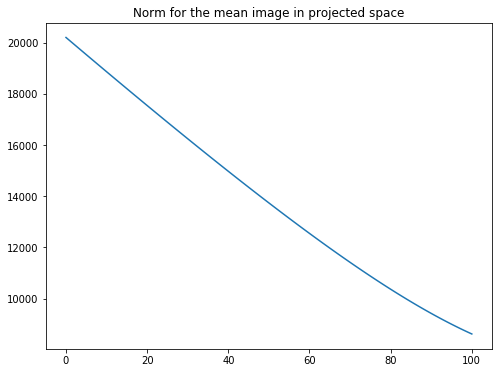

In [29]:
f, ax = plt.subplots(1,1)
ax.plot(norm_vary)
ax.set_title('Norm for the mean image in projected space')

Text(0.5,1,'Norm for mean image in original space')

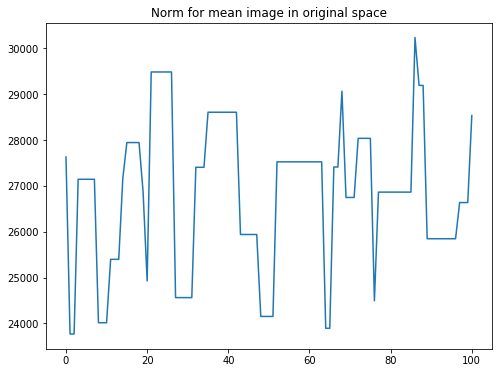

In [30]:
norm_vary = list()
norm_im = list()
lbd = np.linspace(0, 1, 101)
for i in range(101):
    test = (lbd[i] * Z[person1]) + ((1-lbd[i]) * Z[person2])
    norm_vary.append(norm(test))
    pred = lin.predict(test.reshape(1, -1))
    im = Image.fromarray(pred.reshape(*img_shape))
    norm_im.append(norm(im))
f, ax = plt.subplots(1,1)
ax.plot(norm_im)
ax.set_title('Norm for mean image in original space')

Even after extensive hyperparamter tuning, we are unable to learn a reasonable regressor hence we use the convex combination approach in him dim.

### Method 2

Instead of choosing a path from the graph, manually choosing a set of points which visibbly lie on a 2D manifold. For regeneration of sub-sampled points, we use convex combinations of the consecutive pairs in high dimensional space itself.

In [31]:

#Interesting paths with N4D3 model
#imlist = [1912,3961,2861,4870,146,6648]
#imlist = [3182,5012,5084,1113,2333,1375]
#imlist = [5105,5874,4255,2069,1178]
#imlist = [3583,2134,1034, 3917,3704, 5920,6493]
#imlist = [1678,6535,6699,344,6677,5115,6433]

#Interesting paths with N2D3 model
imlist = [1959,3432,6709,4103, 4850,6231,4418,4324]
#imlist = [369,2749,1542,366,1436,2836]

#Interesting paths with N2D2 model
#imlist = [2617,4574,4939,5682,1917,3599,6324,1927]

In [32]:
N=25
lbd = np.linspace(0, 1, N)
counter = 0
for count, i in enumerate(imlist):
    if count != len(imlist) - 1:
        person1 = i
        person2 = imlist[count + 1]
        for j in range(N):
            im = (lbd[j] * ims[person2]) + ((1 - lbd[j]) * ims[person1])
            im = Image.fromarray(im.reshape((218, 178)))
            im = im.convert('RGB')
            im.save('{}.png'.format(counter))
            counter += 1

In [33]:
os.system("ffmpeg -f image2 -r 10 -i ./%d.png -vcodec mpeg4 -y ./method2.mp4")

0

Please check the generated video in the same enclosing folder.

Now we can obbserve that the video has quite smooth transitions in terms of either similar head poses, hair styles or face shapes, etc.